In [ ]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Deep_learning-datasets/income.csv')

In [ ]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [ ]:
df['label'].value_counts()

,count
label,
0,21700
1,8300


In [ ]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [ ]:
cat_cols = ['sex', 'education', 'marital-status','workclass', 'occupation']
cont_cols = ['age','hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [ ]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [ ]:
df.dtypes

,0
age,int64
sex,category
education,category
education-num,int64
marital-status,category
workclass,category
occupation,category
hours-per-week,int64
income,object
label,int64


In [ ]:
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,23,Female,HS-grad,9,Never-married,Private,Other-service,50,<=50K,0
1,37,Female,Prof-school,15,Married,State-gov,Prof-specialty,39,>50K,1
2,34,Male,Some-college,10,Divorced,Private,Adm-clerical,40,<=50K,0
3,31,Male,HS-grad,9,Married,Private,Craft-repair,40,>50K,1
4,20,Female,Some-college,10,Never-married,Private,Sales,25,<=50K,0


In [ ]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [ ]:
cat_szs

[2, 14, 6, 5, 12]

In [ ]:
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]

In [ ]:
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [ ]:
cat_cols

['sex', 'education', 'marital-status', 'workclass', 'occupation']

In [ ]:
sex = df['sex'].cat.codes.values
education = df['education'].cat.codes.values
maritalstatus = df['marital-status'].cat.codes.values
workclass = df['workclass'].cat.codes.values
occupation = df['occupation'].cat.codes.values

In [ ]:
cats = np.stack([sex,education,maritalstatus,workclass,occupation],axis=1)

In [ ]:
cats[:5]

array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       [ 1, 10,  1,  2,  1],
       [ 0, 13,  3,  2,  9]], dtype=int8)

In [ ]:
cats = torch.tensor(cats,dtype=torch.int64)

In [ ]:
conts = np.stack([df[col].values for col in cont_cols],1)

In [ ]:
conts[:5]

array([[23, 50],
       [37, 39],
       [34, 40],
       [31, 40],
       [20, 25]])

In [ ]:
conts = torch.tensor(conts,dtype=torch.float32)

In [ ]:
conts.dtype

torch.float32

In [ ]:
y = torch.tensor(df[y_col].values).flatten()

In [ ]:
cats.shape

torch.Size([30000, 5])

In [ ]:
conts.shape

torch.Size([30000, 2])

In [ ]:
y.shape

torch.Size([30000])

In [ ]:
batch_size = 12000
test_size = int(batch_size*0.2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [ ]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()

        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        # Assign a variable to hold a list of layers
        layerlist = []

        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)

        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)

        # Set up model layers
        x = self.layers(x)
        return x

In [ ]:
torch.manual_seed(33)
model = TabularModel(emb_szs,conts.shape[1],2,[200,100],p=0.4)

In [ ]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, cont_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.85781312
epoch:  26  loss: 0.47744796
epoch:  51  loss: 0.43207642
epoch:  76  loss: 0.40467817
epoch: 101  loss: 0.37760422
epoch: 126  loss: 0.34979737
epoch: 151  loss: 0.33308277
epoch: 176  loss: 0.32528761
epoch: 201  loss: 0.31558031
epoch: 226  loss: 0.31012186
epoch: 251  loss: 0.30427423
epoch: 276  loss: 0.30091867
epoch: 300  loss: 0.29374960

Duration: 30 seconds


Text(0.5, 0, 'Epoch')

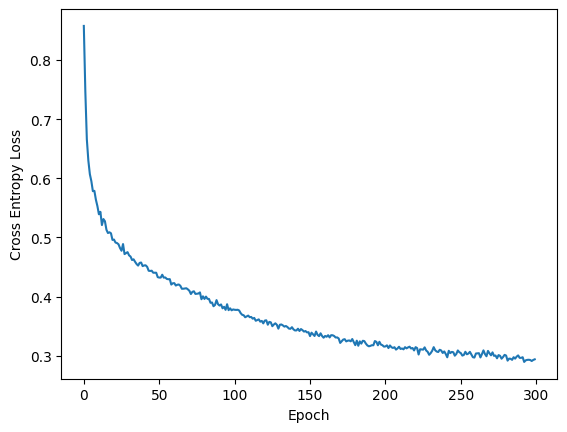

In [ ]:
plt.plot(range(epochs),losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')

In [ ]:
with torch.no_grad():
  y_val = model(cat_test, cont_test)
  loss = criterion(y_val,y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.30474418


In [ ]:
rows = len(y_val)
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([0.3068, 0.3830])      1      1   
tensor([ 2.7314, -2.1198])    0      0   
tensor([ 1.4972, -0.7574])    0      0   
tensor([-0.8180,  1.3713])    1      1   
tensor([0.2249, 0.2351])      1      1   
tensor([-0.5220,  0.8776])    1      1   
tensor([ 1.4700, -1.0455])    0      0   
tensor([-0.9148,  0.4444])    1      0   
tensor([ 1.4754, -0.9151])    0      0   
tensor([ 4.9548, -3.0276])    0      0   
tensor([ 1.7622, -2.3935])    0      0   
tensor([ 3.0061, -2.6571])    0      0   
tensor([ 1.5189, -2.3833])    0      0   
tensor([ 1.6105, -0.9359])    0      0   
tensor([ 1.0554, -0.6279])    0      1   
tensor([-0.6484,  0.7761])    1      1   
tensor([ 3.3662, -5.6917])    0      0   
tensor([ 1.2823, -1.3001])    0      0   
tensor([-0.3106,  0.0716])    1      1   
tensor([-0.1724,  0.4382])    1      1   
tensor([ 3.1000, -2.1164])    0      0   
tensor([ 2.7001, -1.8083])    0      0   
tensor([ 1.9034, -2.7796])    0   

In [ ]:
if len(losses) == epochs:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Deep_learning-datasets/CensusIncomeModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [ ]:
model2 = TabularModel(emb_szs, 2, 2, [200,100], p=0.4)

In [ ]:
model2.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning-datasets/CensusIncomeModel.pt',weights_only=True));
model2.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [ ]:
# DON'T WRITE HERE
def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9,
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)

    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')

In [ ]:
test_data(model2)

What is the person's age? (18-90)  22
What is the person's sex? (Male/Female) male
What is the person's education level? (3-16) 12
What is the person's marital status? married
What is the person's workclass? private
What is the person's occupation? sales
How many hours/week are worked? (20-90)  40

The predicted label is 0
